**SIMPAN DATASET CIFAR 10**

In [23]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import random

os.makedirs("custom_dataset/noisy", exist_ok=True)
os.makedirs("custom_dataset/clean", exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(cifar10, batch_size=1, shuffle=True)

def add_salt_pepper_noise(img_np, amount=0.02):
    """Tambahkan salt and pepper noise pada gambar numpy"""
    row, col, ch = img_np.shape
    s_vs_p = 0.5
    out = np.copy(img_np)

    # Salt
    num_salt = np.ceil(amount * img_np.size * s_vs_p)
    coords = [np.random.randint(0, i, int(num_salt)) for i in img_np.shape]
    out[coords[0], coords[1], coords[2]] = 255

    # Pepper
    num_pepper = np.ceil(amount * img_np.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i, int(num_pepper)) for i in img_np.shape]
    out[coords[0], coords[1], coords[2]] = 0

    return out

num_images = 50
for i, (img, _) in tqdm(enumerate(loader), total=num_images):
    if i >= num_images:
        break

    clean_img = transforms.ToPILImage()(img[0])
    img_np = np.array(clean_img)

    noisy_img = img_np + np.random.normal(0, 40, img_np.shape)

    noisy_img = add_salt_pepper_noise(noisy_img, amount=0.02)

    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    noisy_img = Image.fromarray(noisy_img)

    clean_img.save(f"custom_dataset/clean/{i:03d}.png")
    noisy_img.save(f"custom_dataset/noisy/{i:03d}.png")


100%|██████████| 50/50 [00:00<00:00, 89.47it/s]


MODEL AUTOENCODER

Epoch 1, Loss: 0.1818
Epoch 2, Loss: 0.1281
Epoch 3, Loss: 0.1027
Epoch 4, Loss: 0.0976
Epoch 5, Loss: 0.0831
Epoch 6, Loss: 0.0827
Epoch 7, Loss: 0.0770
Epoch 8, Loss: 0.0768
Epoch 9, Loss: 0.0616
Epoch 10, Loss: 0.0641
Epoch 11, Loss: 0.0597
Epoch 12, Loss: 0.0604
Epoch 13, Loss: 0.0579
Epoch 14, Loss: 0.0729
Epoch 15, Loss: 0.0643
Epoch 16, Loss: 0.0592
Epoch 17, Loss: 0.0620
Epoch 18, Loss: 0.0562
Epoch 19, Loss: 0.0609
Epoch 20, Loss: 0.0590
Epoch 21, Loss: 0.0576
Epoch 22, Loss: 0.0547
Epoch 23, Loss: 0.0612
Epoch 24, Loss: 0.0444
Epoch 25, Loss: 0.0637
Epoch 26, Loss: 0.0533
Epoch 27, Loss: 0.0572
Epoch 28, Loss: 0.0463
Epoch 29, Loss: 0.0578
Epoch 30, Loss: 0.0501
Epoch 31, Loss: 0.0695
Epoch 32, Loss: 0.0687
Epoch 33, Loss: 0.0668
Epoch 34, Loss: 0.0511
Epoch 35, Loss: 0.0507
Epoch 36, Loss: 0.0469
Epoch 37, Loss: 0.0490
Epoch 38, Loss: 0.0546
Epoch 39, Loss: 0.0516
Epoch 40, Loss: 0.0590
Epoch 41, Loss: 0.0452
Epoch 42, Loss: 0.0515
Epoch 43, Loss: 0.0548
Epoch 44, Loss: 0.03

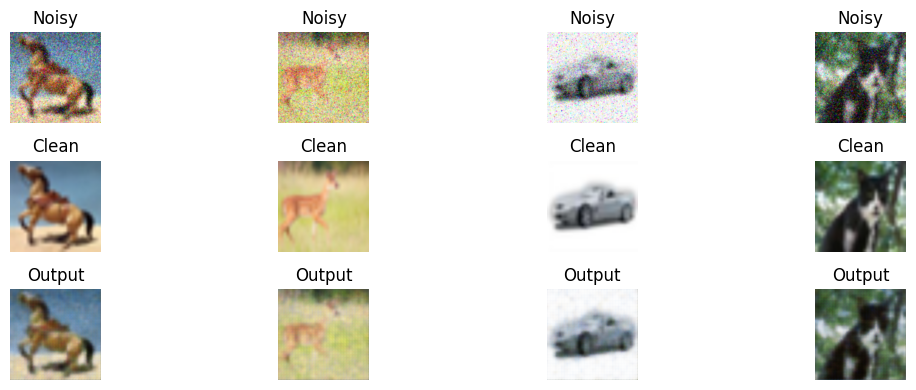

In [24]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_dir = noisy_dir
        self.clean_dir = clean_dir
        self.image_names = sorted(os.listdir(noisy_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        noisy_path = os.path.join(self.noisy_dir, self.image_names[idx])
        clean_path = os.path.join(self.clean_dir, self.image_names[idx])

        noisy_image = Image.open(noisy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = CustomImageDataset('custom_dataset/noisy', 'custom_dataset/clean', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

class AsymmetricAutoencoder(nn.Module):
    def __init__(self):
        super(AsymmetricAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AsymmetricAutoencoder().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    total_loss = 0
    for noisy_img, clean_img in dataloader:
        noisy_img = noisy_img.to(device)
        clean_img = clean_img.to(device)

        output = model(noisy_img)
        loss = criterion(output, clean_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

def imshow_tensor(tensor):
    img = tensor.cpu().detach().numpy().transpose((1, 2, 0))
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')

noisy, clean = next(iter(dataloader))
output = model(noisy.to(device))

plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(3, 4, i+1)
    imshow_tensor(noisy[i])
    plt.title("Noisy")
    plt.subplot(3, 4, i+5)
    imshow_tensor(clean[i])
    plt.title("Clean")
    plt.subplot(3, 4, i+9)
    imshow_tensor(output[i])
    plt.title("Output")
plt.tight_layout()
plt.show()
